# Python flight analysis, Leonardo Style


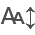

In [1]:
from aerofiles.igc import Reader
import pandas as pd
import geopandas as gpd
import urllib.request
from urllib.parse import urlparse
import os
import plotly.express as px
import folium
import rasterio
from datetime import datetime, date, time
import requests 
import pytz
import haversine as hs
from haversine import Unit
from itables import init_notebook_mode
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point
from bs4 import BeautifulSoup
import re
import urllib.parse
import math
from pathlib import Path
from dotenv import load_dotenv
import dateutil



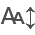

In [57]:
init_notebook_mode(all_interactive=True) # setup interactive mode for tables

load_dotenv()  # load environment variables from .env file
'''
.env file format:

nasa_token=6sdfsdfs4fs5dfsdf...
geonames_user=myusername 

Obtain a NASA token at https://urs.earthdata.nasa.gov/users/<YOURUSERNAME>/user_tokens
For geonames (https://www.geonames.org) user your username

'''

NASA_TOKEN = os.getenv("nasa_token")
GEONAMES_USER = os.getenv("geonames_user")

LEONARDO_TAKEOFFS = "leonardo_takeoff_sites.geojson"

# A list of Leonardo records
IGC_FILES = [
            'http://www.sky.gr/leonardo/flight/112210',
            'http://www.sky.gr/leonardo/flight/108691',
            'http://www.sky.gr/leonardo/flight/111999',
            'http://www.sky.gr/leonardo/flight/112201'
            ]

IGC_INDEX = 0 # pick an item from IGC_FILES list

DATA_DIR=Path('data')

DEM_DIR = DATA_DIR / 'dem'
IGC_DIR = DATA_DIR / 'igc'
VECTOR_DIR = DATA_DIR / 'vector'


stat_dic={} # dictionary to keep flight statistics

In [58]:
# Read leonardo takeoff sites
leonardo_takeoffs = gpd.read_file(VECTOR_DIR / LEONARDO_TAKEOFFS)
leonardo_takeoffs = leonardo_takeoffs.reset_index()
leonardo_takeoffs = leonardo_takeoffs.rename(columns={"index":"takeoff_ID"})

In [59]:

def getIGC(url):
    '''Web Scraping to get igc url '''
    # Send a GET request to the webpage
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.content, 'html.parser')
    
        # Find all anchor tags with href attributes
        links = soup.find_all('a', href=True)
    
        # Filter the links to find ones that end with '.igc'
        igc_links = [link['href'] for link in links if link['href'].endswith('.igc')]
    
        # Print .igc URL
        igc_file = f'http://{urlparse(url).netloc}{igc_links[0]}'
        return(igc_file)
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")


In [60]:
# get URL of Leonardo flight
igc_url = getIGC(IGC_FILES[IGC_INDEX])

# get igc filename
igc_filename=IGC_DIR / os.path.basename(urlparse(igc_url).path)

# Download igc
_ = urllib.request.urlretrieve(igc_url, igc_filename)


In [61]:
# open IGC

with open(igc_filename, 'r') as f:

    parsed = Reader().read(f)

# # inspection of igc
# for k, v  in parsed.items():
#     print(k)

# Check if it has any G records
stat_dic['G_record'] = None
if len(parsed['security_records'][1])>0:
    stat_dic['G_record'] = True

In [62]:
# get B records
records = parsed['fix_records'][1]

# get flight date
utc_date = parsed['header'][1]['utc_date']


In [63]:
# convert B records to pandas dataframe
df = pd.DataFrame.from_records(records)

# generate Datetime column
df['datetime'] = df.apply(lambda r : pd.Timestamp.combine(utc_date,r['time']),1) 
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
df = df.set_index(df['datetime'])

# keep valid sentences, A=3D
df = df[df['validity']=='A'] # Use A for a 3D fix and V for a 2D fix (no GNSS altitude) or for no GNSS data.

#df = df.asfreq('s') # set timeseries frequency

df = df.dropna(axis=0, how='all')
df

time       lat        lon validity  \
datetime                                                            
2024-06-08 15:33:19+00:00  15:33:19  38.20725  23.252500        A   
2024-06-08 15:33:20+00:00  15:33:20  38.20725  23.252500        A   
2024-06-08 15:33:21+00:00  15:33:21  38.20725  23.252500        A   
2024-06-08 15:33:22+00:00  15:33:22  38.20725  23.252483        A   
2024-06-08 15:33:23+00:00  15:33:23  38.20725  23.252500        A   
...                             ...       ...        ...      ...   
2024-06-08 16:56:59+00:00  16:56:59  38.20710  23.251867        A   
2024-06-08 16:57:00+00:00  16:57:00  38.20710  23.251867        A   
2024-06-08 16:57:01+00:00  16:57:01  38.20710  23.251867        A   
2024-06-08 16:57:02+00:00  16:57:02  38.20710  23.251867        A   
2024-06-08 16:57:03+00:00  16:57:03  38.20710  23.251867        A   

                           pressure_alt  gps_alt  LAD  LOD  \
datetime                                                     
2024-06-08 15:33:19+00:00             0      653    2    0   
2024-06-08 15:33:20+00:00             0      653    1    0   
2024-06-08 15:33:21+00:00             0      652    1    0   
2024-06-08 15:33:22+00:00             0      652    1    9   
2024-06-08 15:33:23+00:00             0      652    3    0   
...                                 ...      ...  ...  ...   
2024-06-08 16:56:59+00:00             0      657    5    5   
2024-06-08 16:57:00+00:00             0      657    5    5   
2024-06-08 16:57:01+00:00             0      657    5    5   
2024-06-08 16:57:02+00:00             0      657    5    5   
2024-06-08 16:57:03+00:00             0      657    5    5   

                                           datetime  
datetime                                             
2024-06-08 15:33:19+00:00 2024-06-08 15:33:19+00:00  
2024-06-08 15:33:20+00:00 2024-06-08 15:33:20+00:00  
2024-06-08 15:33:21+00:00 2024-06-08 15:33:21+00:00  
2024-06-08 15:33:22+00:00 2024-06-08 15:33:22+00:00  
2024-06-08 15:33:23+00:00 2024-06-08 15:33:23+00:00  
...                                             ...  
2024-06-08 16:56:59+00:00 2024-06-08 16:56:59+00:00  
2024-06-08 16:57:00+00:00 2024-06-08 16:57:00+00:00  
2024-06-08 16:57:01+00:00 2024-06-08 16:57:01+00:00  
2024-06-08 16:57:02+00:00 2024-06-08 16:57:02+00:00  
2024-06-08 16:57:03+00:00 2024-06-08 16:57:03+00:00  

[5025 rows x 9 columns]

In [64]:
# Fix dates for night flights
today_indexes = df.index.indexer_between_time(df.head(1).index.time[0], time.fromisoformat('23:59:59'), include_end=True) # get row indexes that are in the day period between the first point timestamp till the end of day
list_of_indexes = np.arange(len(df.index)) # get full list of indexes
nextdayInd = np.setdiff1d(list_of_indexes, today_indexes).tolist()

if nextdayInd:
    df = df.reset_index(drop=True)
    df.loc[nextdayInd,'datetime'] = df.loc[nextdayInd,'datetime']+ np.timedelta64(1,'D')
    df=df.set_index('datetime', drop=False)



In [65]:
# Create geopandas dataframe
gdf = gpd.GeoDataFrame(
    df,
    geometry = gpd.points_from_xy(
        x = df.lon,
        y = df.lat,
        crs = 'EPSG:4326', 
    )

)
bounds  = gdf.total_bounds



In [66]:



#gdf.index = gdf.index.tz_convert(pytz.timezone('Europe/Athens'))

# apply a filter of 20'' step from the start
start_time = pd.to_datetime(gdf.head(1).index.values[0],utc=True) 
end_time = pd.to_datetime(gdf.tail(1).index.values[0],utc=True)

#generate list of datatime obj with 20'' interval, also include end_time
dti = pd.date_range(start_time,end_time + pd.to_timedelta(20,'s'), freq="20s", tz=dateutil.tz.tzutc()) #tz = pytz.timezone('Europe/Athens')
gdf = gdf[gdf.index.isin(dti)]


#pd.infer_freq(gdf.index)


In [68]:
gdf['shift_lat'] = gdf.lat.shift(-1)
gdf['shift_lon'] = gdf.lon.shift(-1)

# Fligh duration
stat_dic['fligh_duration'] = gdf.index.max()-gdf.index.min()

# max vario, gps height
df.pressure_alt.max(), df.gps_alt.max(), df.gps_alt.min()


stat_dic['gps_max_altitude']=df.gps_alt.max()
stat_dic['gps_min_altitude']= df.gps_alt.min()
stat_dic['takeoff_time']= gdf.index.min()
stat_dic['landing_time']= gdf.index.max()
stat_dic['takeoff_ground'] = None


In [70]:
# Get ground Altitude from (ASTER) Global Digital Elevation Model (GDEM) Version 3 (ASTGTM) 

# Search tiles
req = requests.get(f'https://cmr.earthdata.nasa.gov/search/granules.json?short_name=ASTGTM&version=003&page_size=2000&pageNum=1&bounding_box={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]}').json()['feed']['entry'] 
fileList = [g['links'][0]['href'] for g in req]   # download these files


# Download
for url in fileList:
    header={"Authorization": f"Bearer {NASA_TOKEN}"}
    
    
    response = requests.get(url, headers=header)
    if response.status_code == 200:
        content = response.content
        file_name = url.split('/')[-1]
        data_path = DEM_DIR / file_name
        if not data_path.is_file(): # download tif if not exists
            data_path.write_bytes(content)

# get filenames from URLs
tifs = [DEM_DIR / os.path.basename(urlparse(tif).path) for tif in fileList]


# attach ground altitude
try:
    # If there are multiple tiffs
    if len(tifs)>1: # not tested it
    
        for file in tifs:
            src = rasterio.open(file)
            src_files_to_mosaic.append(src)
        
        nodata = np.iinfo(mosaic.dtype).max
        
        mosaic, out_trans = merge(src_files_to_mosaic, nodata=nodata)
        
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": mosaic.shape[1],
                         "width": mosaic.shape[2],
                         "nodata": nodata,
                         "transform": out_trans})
    
        
        # https://rasterio.readthedocs.io/en/stable/topics/writing.html  
        # Register GDAL format drivers and configuration options with a context manager.
        with rasterio.Env():
            with MemoryFile() as memfile:
                with memfile.open(**out_meta) as dst:
                    dst.write(mosaic)
                
                with memfile.open() as dataset:  # Reopen
                    #merged_tif = dataset.read() 
                    coord_list = [(x, y) for x, y in zip(gdf["lon"], gdf["lat"])]
    
    
    else: # if there is only one tiff
       # use first item of list 
        tif = tifs[0]
        with rasterio.open(tif) as src:
            coord_list = [(x, y) for x, y in zip(gdf["lon"], gdf["lat"])]
            
            gdf["ground"] = [x[0] for x in src.sample(coord_list)]
except:
    gdf["ground"] = 0
    
    


# get statistics
stat_dic['takeoff_gps_alt'] = gdf.loc[start_time].gps_alt
stat_dic['takeoff_ground'] = gdf.loc[start_time].ground



In [55]:
coordinates = [(y,x) for x,y in zip(gdf['lon'] , gdf['lat'])]

# Create the map and add the line
m = folium.Map(location=[bounds[1], bounds[0]], zoom_start=13)

folium.PolyLine(
    locations=coordinates,
    color="#0000FF",
    weight=1,
    tooltip=igc_filename,
).add_to(m)

locations = gdf.iloc[[0, -1]][['lat', 'lon', 'datetime']]
locationlist = locations[['lat', 'lon']].values.tolist()

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=locations['datetime'][point]).add_to(m)
m


/tmp/ipykernel_23275/3655718832.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [23]:


def calc_distance(lat1, lon1, lat2, lon2):
    # Earth radius in meters
    d_fak = 6371000.0
    
    # Convert degrees to radians
    latx = math.radians(lat1)
    lonx = math.radians(lon1)
    laty = math.radians(lat2)
    lony = math.radians(lon2)
    
    # Compute differences
    sinlat = math.sin((latx - laty) / 2)
    sinlon = math.sin((lonx - lony) / 2)
    
    # Compute distance
    return 2 * math.asin(math.sqrt(sinlat**2 + sinlon**2 * math.cos(latx) * math.cos(laty))) * d_fak





In [24]:
# Distance between points
gdf['distance'] = gdf.apply(lambda x: calc_distance(  x.lat, x.lon, x.shift_lat, x.shift_lon,), axis=1)
gdf['distance_haversine'] = gdf.apply(lambda x: hs.haversine((x.lat, x.lon), (x.shift_lat, x.shift_lon)), axis=1) # python has a package for haversine distance
#gdf['distance_proj'] = gdf.distance(gdf.shift(1)) # use this for project distance,

# Distance from take off
# get lat long of takeoff poinτ
takeoff_long = gdf.loc[start_time].lon
takeoff_lat= gdf.loc[start_time].lat


gdf['takeoff_distance'] = gdf.apply(lambda x: calc_distance(x.lat, x.lon, takeoff_lat,takeoff_long), axis=1) #as meters
gdf['takeoff_distance'] = gdf['takeoff_distance']/1000 #as km

# Diff time 
gdf.loc[:, 'time_diff'] = gdf['datetime'].diff()

stat_dic['takeoff_coords'] = (takeoff_lat,takeoff_long)
stat_dic['landing_coords'] = (gdf.loc[pd.to_datetime(gdf.tail(1).index.values[0],utc=True)].lat,
                              gdf.loc[pd.to_datetime(gdf.tail(1).index.values[0],utc=True)].lon)



In [25]:
gdf['speed'] = gdf['distance'] /gdf['time_diff'].dt.total_seconds() # as m/sec
gdf['speed'] = gdf['speed']* 3.6 # convert to km/h


In [26]:
stat_dic['max_speed'] = gdf.speed.max()
stat_dic['mean_speed'] = gdf.speed.mean()

stat_dic['altitude_gain'] = stat_dic['gps_max_altitude'] - stat_dic['takeoff_ground']

In [27]:
# Find takeoff distance from first point location
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf
  
stat_dic['takeoff_name'] = ckdnearest(gdf.head(1), leonardo_takeoffs).iloc[0]['Name'].strip()

In [44]:
# Check if pressure_alt has altitude, if not, fill the column with gps altitude values (gps_alt)
if (gdf.pressure_alt == 0).all():
     gdf.pressure_alt = gdf.gps_alt


# calculate Vario speed
gdf['pressure_alt_diff'] = gdf[['pressure_alt']].diff(periods=1)
gdf['vario_speed'] = gdf.pressure_alt_diff / gdf.time_diff.dt.total_seconds()

# append vario data to flight statistics 
stat_dic['max_vario_speed'] = gdf['vario_speed'].max()
stat_dic['min_vario_speed'] = gdf['vario_speed'].min()

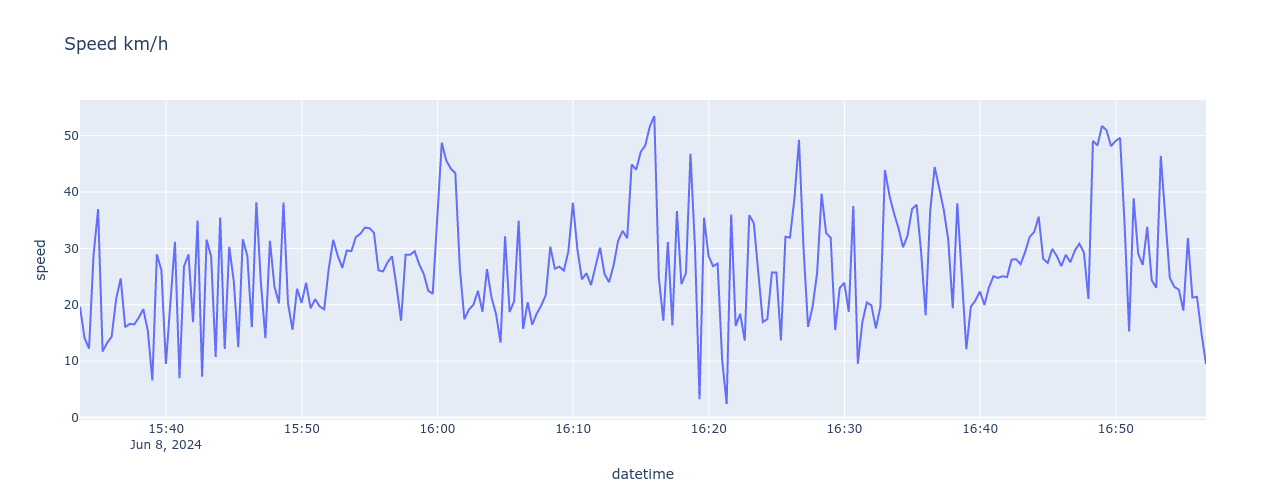

In [45]:
WIDTH, HEIGHT=(1100, 500)
fig1 = px.line(gdf.dropna(subset=['speed']), x="datetime", y="speed", title='Speed km/h', width=WIDTH, height=HEIGHT)
fig1.show()


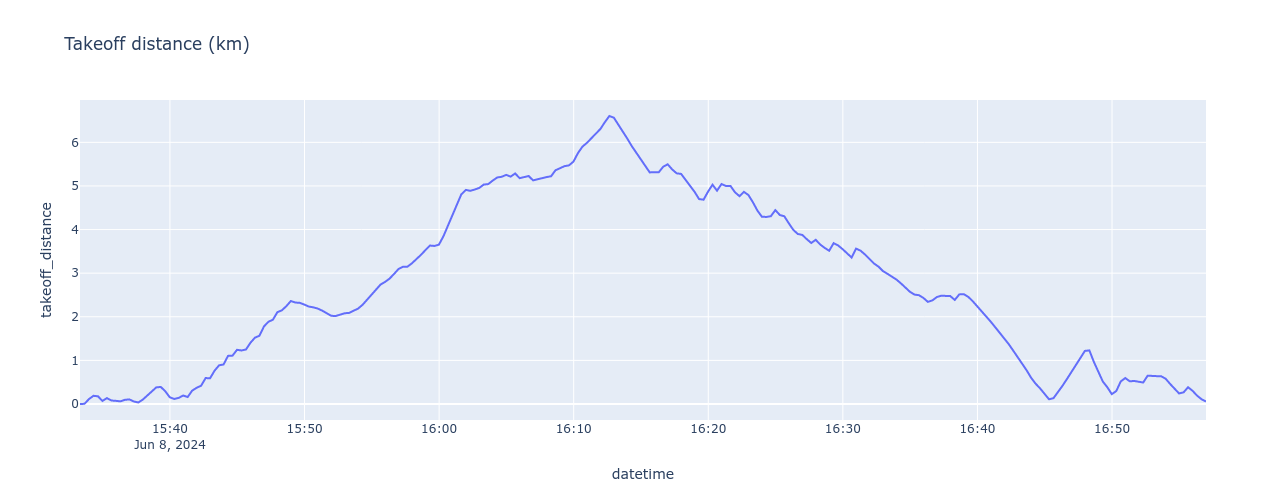

In [46]:
fig2 = px.line(gdf, x="datetime", y="takeoff_distance", title='Takeoff distance (km)',width=WIDTH, height=HEIGHT)
fig2.show()

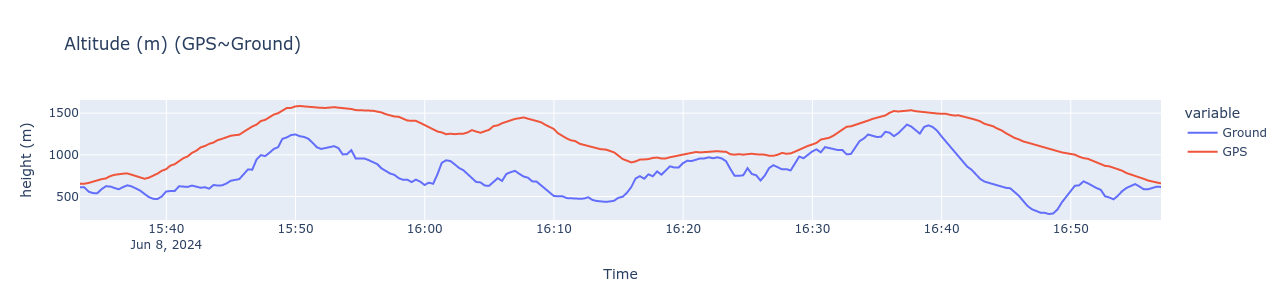

In [47]:
fig3 = px.line(gdf, x="datetime", y=["ground","gps_alt"],title='Altitude (m) (GPS~Ground)', width=1300, height=300).update_layout(
    xaxis_title="Time", yaxis_title="height (m)"
)


newnames = {'gps_alt':'GPS', 'ground': 'Ground'}
fig3.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig3.show()

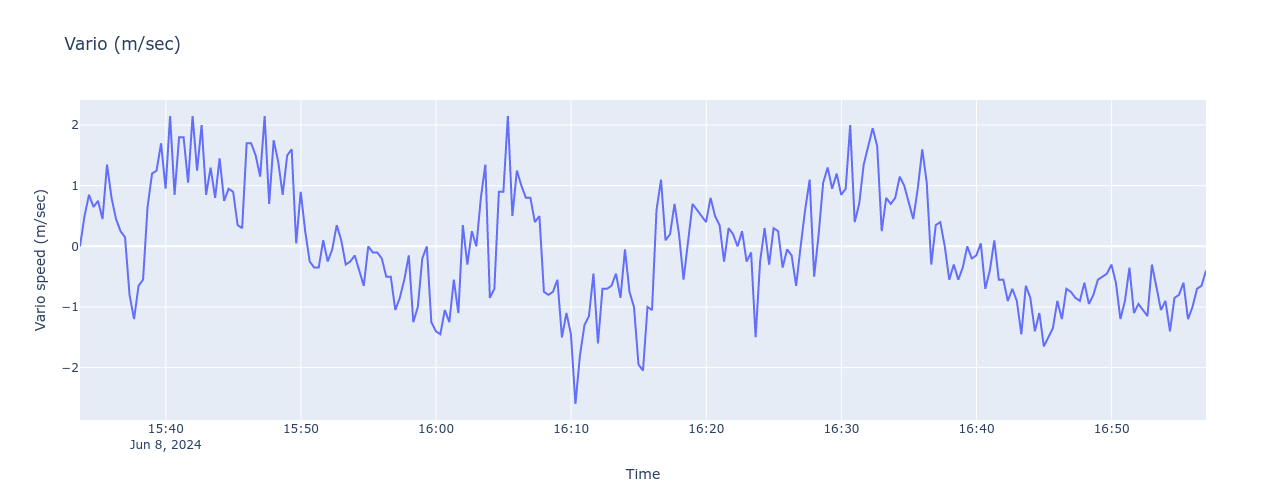

In [48]:
fig4 = px.line(gdf.dropna(subset=['vario_speed']), x="datetime", y="vario_speed", title='Vario (m/sec)', width=WIDTH, height=HEIGHT).update_layout(
    xaxis_title="Time", yaxis_title="Vario speed (m/sec)"
)
fig4.show()

In [49]:
# Find nearby populated place (Geonames API)

response = requests.get(f"http://api.geonames.org/findNearbyPlaceNameJSON?formatted=true \
                        &lat={stat_dic['landing_coords'][0]} \
                        &lng={stat_dic['landing_coords'][1]} \
                        &username={GEONAMES_USER}&style=full")

stat_dic['landing'] = None

if response.status_code == 200:
    landing_name =  response.json()['geonames'][0]['name']
    landing_adminName2 = response.json()['geonames'][0]['adminName2']
    landing_distance = response.json()['geonames'][0]['distance']
    landing_countryCode = response.json()['geonames'][0]['countryCode']

    stat_dic['landing'] = f'{landing_name} at {landing_adminName2} ({landing_countryCode}), ~{float(landing_distance):.2}km'



In [50]:
# Print Flight statistics
stat_dic

{'G_record': True,
 'fligh_duration': Timedelta('0 days 01:23:40'),
 'gps_max_altitude': 1587,
 'gps_min_altitude': 651,
 'takeoff_time': Timestamp('2024-06-08 15:33:19+0000', tz='UTC'),
 'landing_time': Timestamp('2024-06-08 16:56:59+0000', tz='UTC'),
 'takeoff_ground': 611,
 'takeoff_coords': (38.20725, 23.2525),
 'landing_coords': (38.2071, 23.25186666666667),
 'max_speed': 53.499071689162875,
 'mean_speed': 26.84689095572955,
 'takeoff_gps_alt': 653,
 'altitude_gain': 976,
 'takeoff_name': 'Κιθαιρώνας',
 'max_vario_speed': 2.15,
 'min_vario_speed': -2.6,
 'landing': 'Plataies at Voiotía (GR), ~1.5km'}